# Make pretty tables of library strains with growth advantages
Author: Caroline Kikawa

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Color scheme
palette = [
    '#345995', #blue
    '#03cea4', #teal
    '#ca1551', #red
    '#eac435', #yellow
               ]

resultsdir = '../results'

Define MLR strains and pare metadata down to just those strains

In [15]:
# Reduce tree
mlr_strains = [
    'A/TECPAN/017FLU/2023',
    'A/Jeju/1047/2023',
    'A/SENDAI/45/2023',
    'A/Schleswig-Holstein/4/2023',
    'A/Busan/1301/2023',
    'A/Finland/391/2023',
    'A/Saint-Petersburg/RII-166/2023',
    'A/Massachusetts/18/2022',
    'A/Georgia/40/2023',
    'A/Bhutan/0845/2023',
    'A/Ontario/RV00796/2023',
    'A/Sydney/332/2023',
]

# Define antigenic regions 
# Based on Munoz and Deem definitions 
antigenic_regions = [
    list(range(122,146)), # antigenic region A
    list(range(155,160))+list(range(188,198)), # antigenic region B
    list(range(44,55))+list(range(273,380)), # antigenic region C
    list(range(166,181))+list(range(201,219)), # antigenic region D
    list(range(62,65))+list(range(78,94))+list(range(260,265)), # antigenic region E
]

# Read in metadata
HA1_muts_metadata = pd.read_csv('../data/HA_mutations_from_MRCA.csv')
mlr_metadata = HA1_muts_metadata[HA1_muts_metadata['strain'].isin(mlr_strains)].reset_index(drop=True)[['strain','HA1_mutations_list']] # Get just strains with growth advantages
# mlr_metadata['HA1_substitutions_list'] = mlr_metadata['HA1_mutations_list'].str.replace('HA1:','').str.split(',') # Split strings into lists of strings
mlr_metadata = (mlr_metadata[['strain','HA1_mutations_list']] # Reformat and rename columns
                .rename(columns = {'strain': 'Strain name',
                                    'HA1_mutations_list': 'HA1 substitutions'}))

# Match order the strains appear in the tree
mlr_metadata.sort_values(by="Strain name", key=lambda column: column.map(lambda e: mlr_strains.index(e)), inplace=True)
mlr_metadata = mlr_metadata.reset_index(drop=True)

# Show data
mlr_metadata


TypeError: dtype '<class 'list'>' not understood

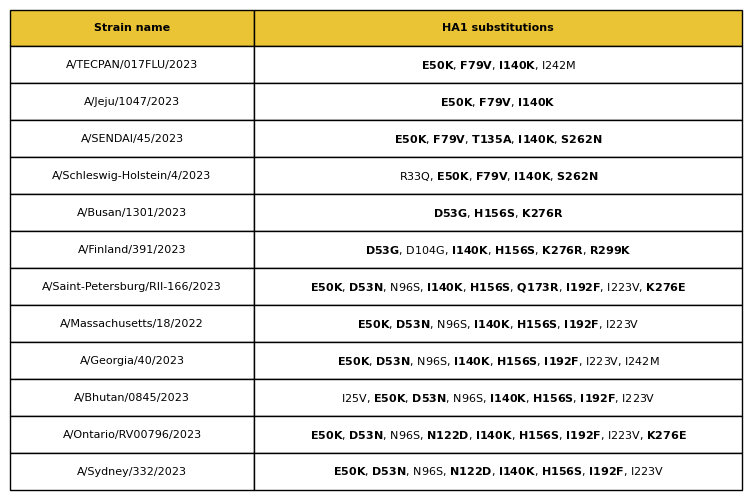

In [24]:
# Make plot
fig, ax = plt.subplots(figsize=(9, 6))
ax.axis('off')

# Prepare cell text with conditional bold formatting for items within lists
formatted_data = []

for _, row in mlr_metadata.iterrows():
    formatted_row = []
    for item in row:
        # if isinstance(item, list):
        if '[' in item:
            item = (item.strip('[').strip(']').replace("'","").split(', '))
            formatted_items = []
            for sub_item in item:
                # Get site number from sub_item
                site = int(sub_item[1:-1])
                # Look in antigenic regions
                regions = [j for i in antigenic_regions for j in i]
                if site in regions:
                    # Bold sites in antigenic regions
                    formatted_items.append(r'$\mathbf{{{}}}$'.format(sub_item))
                
                elif site not in regions:
                    formatted_items.append(sub_item)
                    
            # Join items back into a string, separated by commas
            formatted_row.append(", ".join(formatted_items))
            
        else:
            formatted_row.append(item)
            
    formatted_data.append(formatted_row)

# Create the table
table = ax.table(cellText=formatted_data, colLabels=mlr_metadata.columns, loc='center', cellLoc='center')

# Scale up the table size globally
table.scale(1.5, 1.5)

# Adjust font size and manually resize the first column
for (row, col), cell in table.get_celld().items():
    cell.set_fontsize(18)

    if row == 0: # First row
        # Bold the header row and apply shading
        cell.set_text_props(weight='bold')  # Bold text
        cell.set_facecolor(palette[3])      # Light green shading
    
    if col == 0:  # First column
        cell.set_width(0.35)  # Make it thinner
    else:
        cell.set_width(0.7)  # Wider for other columns
    
    cell.set_height(0.08)  # Uniform height


# Create image. plt.savefig ignores figure edge and face colors, so map them.
plt.savefig(os.path.join(resultsdir, 'growth_advantage_strain_metadata.svg'),
            bbox_inches='tight',
            edgecolor=fig.get_edgecolor(),
            facecolor=fig.get_facecolor(),
            dpi=600
            )
plt.show()
